## Face Recognition using SVM

In [18]:
# Importing libraries

import cv2
import random
import face_recognition
from PIL import Image
import os
import numpy as np
from os import listdir
from os.path import isfile,join
import shutil
import matplotlib.pyplot as plt
from time import time
import logging
import pylab as pl
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

### Face Detection

In [147]:
# Loading Train Images

data_path='Dataset/Data/'

training_data,labels=[],[]

i=0
for class_name in os.listdir(data_path): 
    print(class_name)
    for folder_name in os.listdir(data_path+class_name):
        print(folder_name)
        for files in os.listdir(data_path+class_name+'/'+folder_name):
            image_path=data_path+class_name+'/'+folder_name+'/'
            image=face_recognition.load_image_file(image_path+files)
            #image=cv2.imread(image_path+files)
            image=cv2.resize(image,(100,100))
            gray_image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

            try:
                faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
                faces = faceCascade.detectMultiScale(gray_image,scaleFactor=1.3,minNeighbors=3,minSize=(30, 30))

                for(x,y,w,h) in faces:
                    roi=gray_image[y:y+h,x:x+w]
                    if roi.size is not 0:
                        roi=cv2.resize(roi,(100,100))
                        training_data.append(np.asarray(roi,dtype=np.uint8).flatten())
                        labels.append((i))
            except IndexError as e:
                print('Face not Detected')
    i+=1

print("Total dataset size:")
print("n_samples: %d" % len(training_data))

BG
gates
NOT BG
jack
trump
musk
modi
Total dataset size:
n_samples: 330


In [32]:
# Shuffling the data

data=list(zip(training_data,labels))
random.shuffle(data)

train_data,train_labels=zip(*data)

In [33]:
train_x=np.asarray(train_data)
train_y=np.asarray(train_labels)

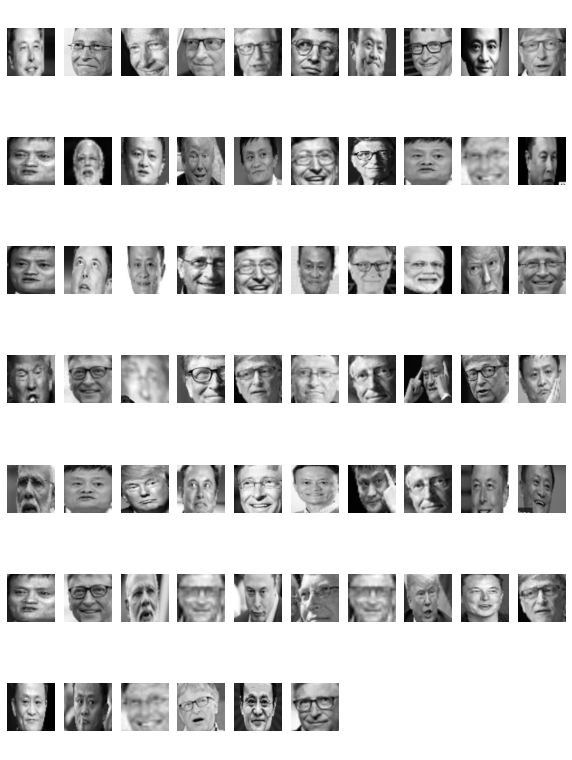

In [35]:
plt.figure(figsize=(10,80))
j=0
for i in range(0,train_x.shape[0],5):
    plt.subplot(40,10,j+1)
    j+=1
    img = Image.fromarray(train_x[i].reshape(100,100),'L')
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.axis('equal')
plt.show()

### Feature Extraction Using PCA

In [148]:
# Feature Extraction using PCA

n_components=150
print( "Extracting the top %d features from %d faces" % (n_components, train_x.shape[0]))

pca=PCA(n_components=n_components,whiten=True,svd_solver='randomized')
pca=pca.fit(train_x)

Extracting the top 150 features from 330 faces


In [37]:
print(pca)

PCA(n_components=150, svd_solver='randomized', whiten=True)


In [38]:
# Projecting the input data on the eigenfaces orthonormal basis

#eigen_faces=pca.components_.reshape((n_components,100,3))

train_x_pca=pca.transform(train_x)

### Training Model

In [149]:
# Train a SVM classification model

param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }

clf = GridSearchCV(SVC(kernel='linear', class_weight='balanced',probability=True), param_grid)
clf = clf.fit(train_x_pca,train_y)

print("Best estimator found by grid search:")
print(clf.best_estimator_)

Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.0001, kernel='linear',
    probability=True)


### Testing Data

In [112]:
# Evaluation of the model on the test set

# Loading Test Images

data_path='new_source/'
testing_data,labels=[],[]

i=0
for class_name in os.listdir(data_path): 
    print(class_name)
    for folder_name in os.listdir(data_path+class_name):
        print(folder_name)
        for files in os.listdir(data_path+class_name+'/'+folder_name):
            image_path=data_path+class_name+'/'+folder_name+'/'
            image=face_recognition.load_image_file(image_path+files)
            image=cv2.resize(image,(100,100))
            gray_image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

            try:
                faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
                faces = faceCascade.detectMultiScale(gray_image,scaleFactor=1.3,minNeighbors=3,minSize=(30, 30))

                for(x,y,w,h) in faces:
                    roi=gray_image[y:y+h,x:x+w]
                    if roi.size is not 0:
                        roi=cv2.resize(roi,(100,100))
                        testing_data.append(np.asarray(roi,dtype=np.uint8).flatten())
                        labels.append((i))
            except IndexError as e:
                print('Face not Detected')
    i+=1


print("No of test samples: %d" % len(testing_data))

# Shuffling the data

data=list(zip(testing_data,labels))
random.shuffle(data)

test_data,test_labels=zip(*data)

test_x=np.asarray(test_data)
test_y=np.asarray(test_labels)

BG
Bill Gates
NOT-BG
SP
DT
Jack
NM
BO
EM
No of test samples: 42


In [113]:
test_x_pca=pca.transform(test_x)

In [150]:
pred_y=clf.predict(test_x_pca)

In [151]:
print(classification_report(test_y, pred_y))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94        27
           1       0.83      1.00      0.91        15

    accuracy                           0.93        42
   macro avg       0.92      0.94      0.93        42
weighted avg       0.94      0.93      0.93        42



In [152]:
print(confusion_matrix(test_y, pred_y, labels=range(2)))

[[24  3]
 [ 0 15]]


In [153]:
from sklearn.metrics import accuracy_score
score = accuracy_score(test_y, pred_y)
print(score)

0.9285714285714286


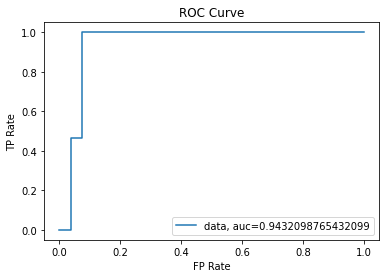

In [156]:
from sklearn import metrics

y_pred_proba = clf.predict_proba(test_x_pca)[::,1]
fpr, tpr, _ = metrics.roc_curve(test_y,  y_pred_proba)
auc = metrics.roc_auc_score(test_y, y_pred_proba)
plt.plot(fpr,tpr,label="data, auc="+str(auc))
plt.title("ROC Curve")
plt.xlabel("FP Rate")
plt.ylabel("TP Rate")
plt.legend(loc=4)
plt.show()

### Testing on Image with Multiple faces

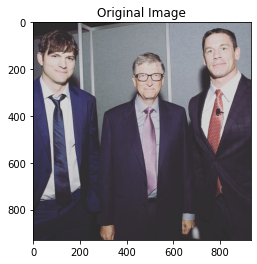

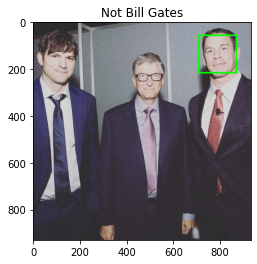

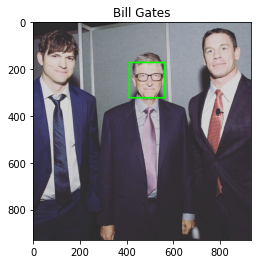

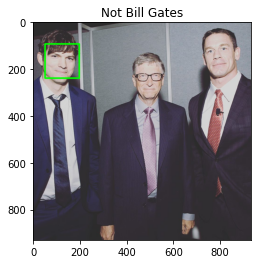

In [155]:
image=face_recognition.load_image_file('bill-gates.jpg')
gray_image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

def display(img,title="Original Image"):
    #img = cv2.cvtColor(np.uint8(img), cv2.COLOR_BGR2RGB)
    plt.imshow(img,cmap='gray'),plt.title(title)
    plt.show()
    
display(image)

try:
    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    faces = faceCascade.detectMultiScale(gray_image,scaleFactor=1.3,minNeighbors=3,minSize=(30, 30))

    for(x,y,w,h) in faces:
        roi=gray_image[y:y+h,x:x+w]
        if roi.size >20000:
            im_copy=image.copy()
            cv2.rectangle(im_copy, (x, y), (x+w, y+h), (0, 255, 0), 5)
            roi=cv2.resize(roi,(100,100))
            roi=roi.flatten()
            roi=roi.reshape(1,-1)
            #roi=np.asarray(roi)
            roi_pca=pca.transform(roi)
            res=clf.predict(roi_pca)
            if res==1:
                display(im_copy,"Not Bill Gates")
            else:
                display(im_copy,"Bill Gates")
            
            
except IndexError as e:
    print('Face not Detected')